<a href="https://colab.research.google.com/github/micheldc55/Deep-Learning/blob/main/mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Redes Generativas Adversariales (GANs)**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Creación de caracteres manuscritos nuevos entrenando con MNIST**</h1></font>

In [ ]:
COLAB                  = True
SAVE_INTERMEDIATE_DATA = False

In [ ]:
if COLAB:
    %tensorflow_version 1.x
    !pip install h5py==2.10.0

import os
#os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

%matplotlib inline

In [ ]:
# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 50

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype(np.float32) / 255 # para que esté entre 0 y 1
X_train = 2*X_train - 1 # para que esté entre -1 y 1
X_train = X_train.reshape(-1, 28*28)

X_train = X_train[y_train>=5] # para simplificar se entrena sólo con los dígitos 5,6,7,8,9
y_train = y_train[y_train>=5] # ídem

In [ ]:
X_train.min(), X_train.max()

(-1.0, 1.0)

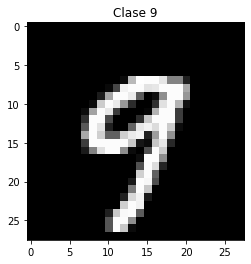

In [ ]:
ind = 20
plt.imshow(X_train[ind].reshape(28,28), cmap='gray')
plt.title("Clase {}".format(y_train[ind]));

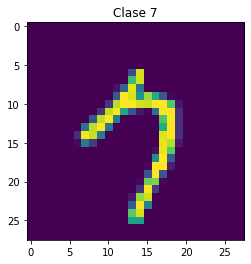

In [ ]:
ind = 202
plt.imshow(X_train[ind].reshape(28,28))
plt.title("Clase {}".format(y_train[ind]));

In [ ]:
X_train.shape

(29404, 784)

**Optimizador**

In [ ]:
adam_gen  = Adam(lr=0.0002, beta_1=0.5) # por defecto: 0.001
adam_disc = Adam(lr=0.0002/2, beta_1=0.5) # El learning rate del discriminador suele ser menor que el del generador. Esto es porque suele ser más fácil clasificar que generar.

In [ ]:
X_train.shape

(29404, 784)

**Red generadora ("generator")**

In [ ]:
randomDim

50

In [ ]:
# entrada: randomDim dimensiones
# salida:  784 valores (entre -1 y 1)
#
# Función de activación estándar en DL:
# ReLU(x): max(0,x)
# En GANs:
# LeakyReLU(x,0.2):
#     si x>0: salida = x
#     si x<0: salida = 0.2*x = -0.2*abs(x)

generator = Sequential()
# Capa de entrada de: randomDim dimensiones
# Observación interesante: El generador no lleva Dropout!!
# rellenar (armamos primero el discriminador --> ver que este es simétrico a ese)
generator.add(Dense(64, input_shape=(randomDim,)))  # No lleva función de activación porque la LeakyReLU se pone como una capa aparte en keras
generator.add(LeakyReLU(0.2))
generator.add(Dense(128))  # No lleva función de activación porque la LeakyReLU se pone como una capa aparte en keras
generator.add(LeakyReLU(0.2))
generator.add(Dense(28*28, activation='tanh'))  # tanh es la sigmoide reescalada entre -1 y 1. Se usa esto porque los valores iniciales de inicialización de la 
                                                # red están entre -1 y 1 y cercanos a 0. Esto hace que la red esté más balanceada
generator.compile(loss='binary_crossentropy',
                      optimizer=adam_gen)

generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                3264      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 784)               101136    
Total params: 112,720
Trainable params: 112,720
Non-trainable params: 0
_________________________________________________________________


**Red discriminadora ("discriminator")**

In [ ]:
# ReLU(z) = max(0,z)
#
# LeakyReLU(z,0.2):
#   si z>0, salida = z
#   si z<=0, salida = -0.2*abs(z)

In [ ]:
# tanh(z) = 2*sigmoide(z) - 1

In [ ]:
def relu(x):
  return x * (x > 0)

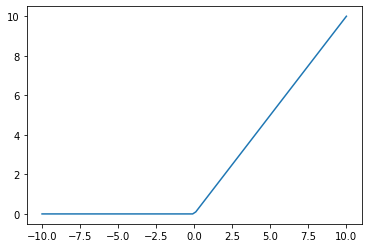

In [ ]:
z = np.linspace(-10, 10, 100)
plt.plot(z, relu(z))

# En las GANs no se usan las ReLu porque son demasiado restrictivas con las neuronas que toman valores negativos (las ignoran).
# En los problemas de clasificación puede ser útil para que la red aprenda cuando ignorar ciertas neuronas, pero en

In [ ]:
discriminator = Sequential()

# rellenar
discriminator.add(Dense(128, input_shape=(28*28,)))  # No lleva función de activación porque la LeakyReLU se pone como una capa aparte en keras
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(64))  # No lleva función de activación porque la LeakyReLU se pone como una capa aparte en keras
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))  # softmax es cuando tengo más de una neurona, para normalizar la salida y que de entre 0 y 1
discriminator.compile(loss='binary_crossentropy',
                      optimizer=adam_disc)

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [ ]:
128 * 28*28 + 128

100480

**Sistema combinado (GAN) generador + disciminador congelado**

In [ ]:
# rellenar

discriminator.trainable = False

ganInput = Input(shape=(randomDim,))
ganOutput = discriminator(generator(ganInput))
gan = Model(input=ganInput, output=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam_gen)

gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 784)               112720    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 108801    
Total params: 221,521
Trainable params: 112,720
Non-trainable params: 108,801
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  import sys


In [ ]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 3))
    plt.plot(range(1,len(dLosses)+1), dLosses,
             label='Discriminitive loss', linewidth=3)
    plt.plot(range(1,len(gLosses)+1), gLosses,
             label='Generative loss', linewidth=3)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(fontsize=14)
    if not COLAB:
        plt.savefig('./images/gan_loss_epoch_{}.png'.format(epoch))
    plt.show()

# Create a wall of generated MNIST images using the generator --> we will train the generator by passing the results to the discriminator
def plotGeneratedImages(epoch, examples=100,
                        dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(len(generatedImages)):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    if SAVE_INTERMEDIATE_DATA:
        plt.savefig('./images/gan_generated_image_epoch_{}.png'.format(epoch))
    plt.show()


def plotImages(images, nrows, ncols, figsize):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(images[i].reshape(28,28), interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    
# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('./models/gan_generator_epoch_{}.h5'.format(epoch))
    discriminator.save('./models/gan_discriminator_epoch_{}.h5'.format(epoch))

In [ ]:
if SAVE_INTERMEDIATE_DATA:
    os.makedirs("./images", exist_ok=True)
    os.makedirs("./models", exist_ok=True)

In [ ]:
len(X_train)

29404

In [ ]:
dLosses = [] # histórico de los valores de la función de coste del discriminador
gLosses = [] # histórico de los valores de la función de coste del generador

In [ ]:
epochs = 200
batchSize=128

batchCount = len(X_train) // batchSize
batchCount

229

In [ ]:
229*128

29312

Epochs: 200
Batch size: 128
Batches per epoch: 229
--------------- Epoch 1 ---------------


100%|██████████| 229/229 [00:03<00:00, 63.81it/s] 


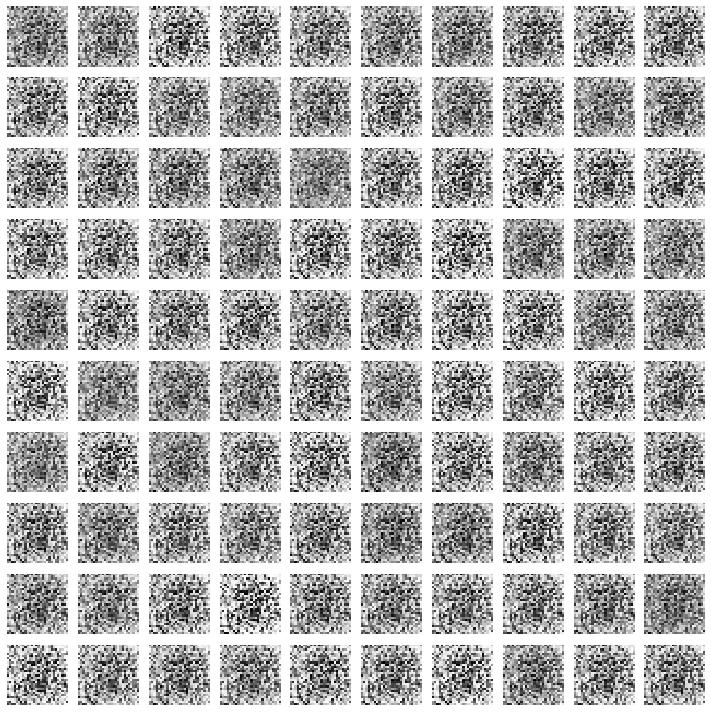

--------------- Epoch 2 ---------------


100%|██████████| 229/229 [00:02<00:00, 99.29it/s]


--------------- Epoch 3 ---------------


100%|██████████| 229/229 [00:02<00:00, 100.58it/s]


--------------- Epoch 4 ---------------


100%|██████████| 229/229 [00:02<00:00, 98.10it/s] 


--------------- Epoch 5 ---------------


100%|██████████| 229/229 [00:02<00:00, 98.21it/s]


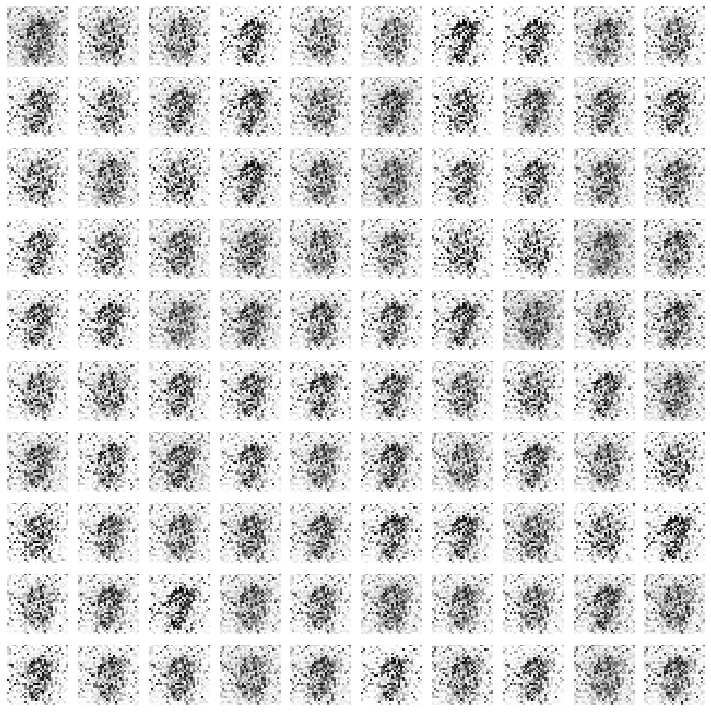

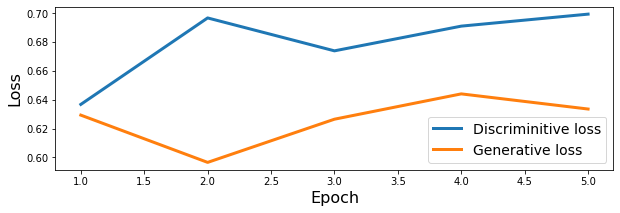

--------------- Epoch 6 ---------------


100%|██████████| 229/229 [00:02<00:00, 98.44it/s]


--------------- Epoch 7 ---------------


100%|██████████| 229/229 [00:02<00:00, 99.97it/s] 


--------------- Epoch 8 ---------------


100%|██████████| 229/229 [00:02<00:00, 98.22it/s]


--------------- Epoch 9 ---------------


100%|██████████| 229/229 [00:02<00:00, 99.32it/s]


--------------- Epoch 10 ---------------


100%|██████████| 229/229 [00:02<00:00, 99.65it/s]


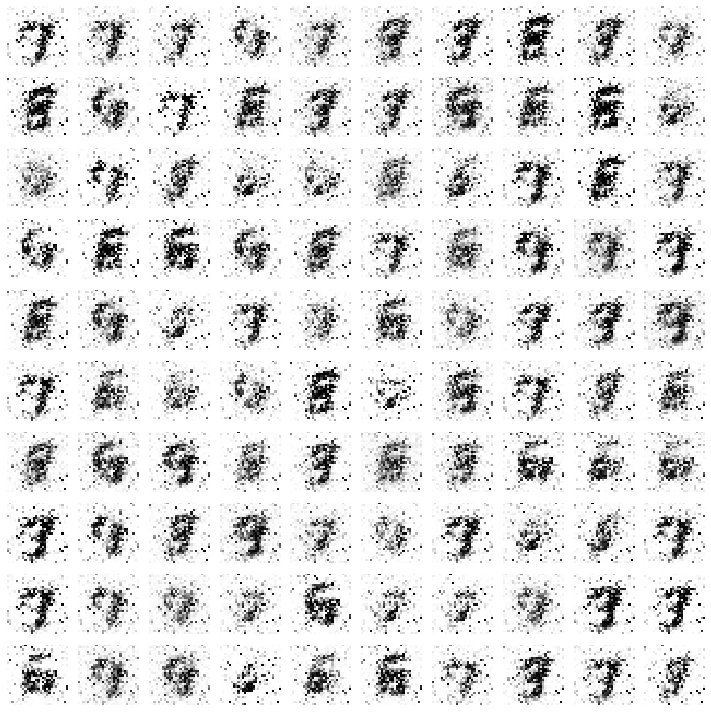

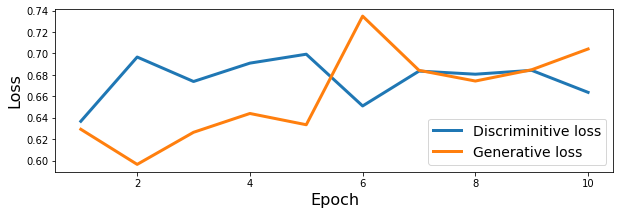

--------------- Epoch 11 ---------------


100%|██████████| 229/229 [00:02<00:00, 96.25it/s]


--------------- Epoch 12 ---------------


100%|██████████| 229/229 [00:02<00:00, 96.21it/s]


--------------- Epoch 13 ---------------


100%|██████████| 229/229 [00:02<00:00, 97.75it/s]


--------------- Epoch 14 ---------------


100%|██████████| 229/229 [00:02<00:00, 98.25it/s]


--------------- Epoch 15 ---------------


100%|██████████| 229/229 [00:02<00:00, 95.87it/s]


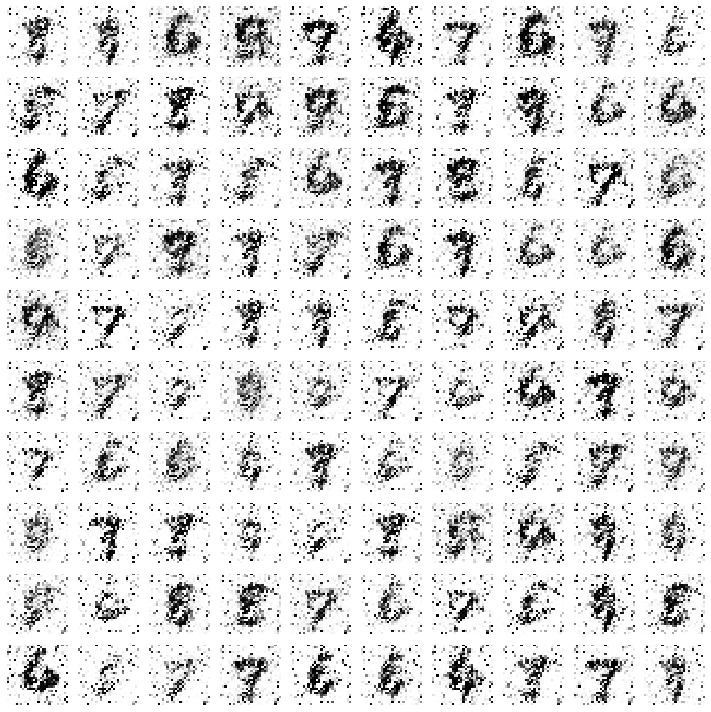

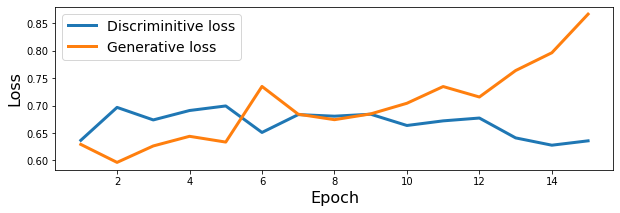

--------------- Epoch 16 ---------------


100%|██████████| 229/229 [00:02<00:00, 95.07it/s]


--------------- Epoch 17 ---------------


100%|██████████| 229/229 [00:02<00:00, 95.07it/s]


--------------- Epoch 18 ---------------


100%|██████████| 229/229 [00:02<00:00, 94.87it/s]


--------------- Epoch 19 ---------------


100%|██████████| 229/229 [00:02<00:00, 94.39it/s]


--------------- Epoch 20 ---------------


100%|██████████| 229/229 [00:02<00:00, 93.55it/s]


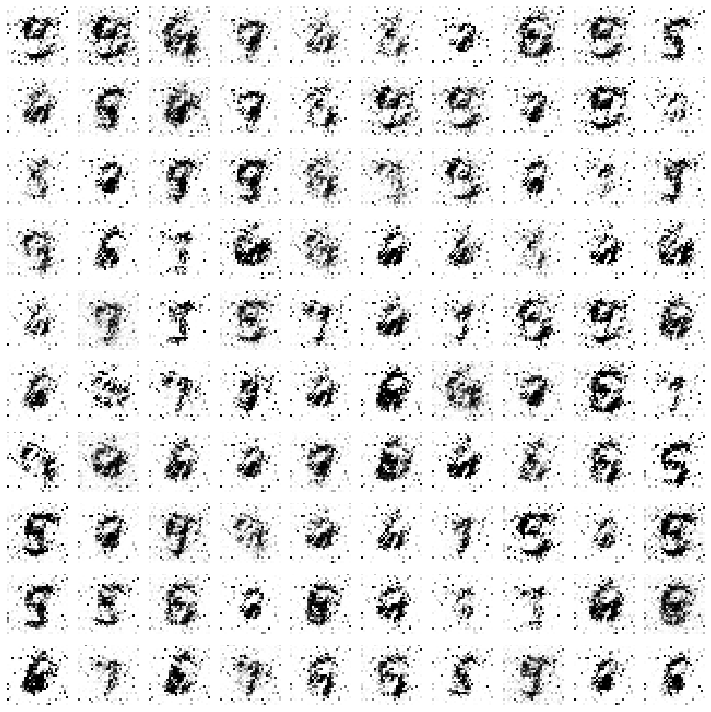

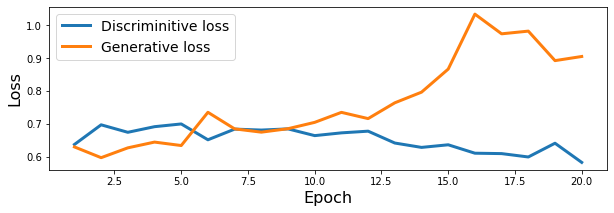

--------------- Epoch 21 ---------------


100%|██████████| 229/229 [00:02<00:00, 90.66it/s]


--------------- Epoch 22 ---------------


100%|██████████| 229/229 [00:02<00:00, 93.29it/s]


--------------- Epoch 23 ---------------


100%|██████████| 229/229 [00:02<00:00, 91.80it/s]


--------------- Epoch 24 ---------------


100%|██████████| 229/229 [00:02<00:00, 93.39it/s]


--------------- Epoch 25 ---------------


100%|██████████| 229/229 [00:02<00:00, 91.45it/s]


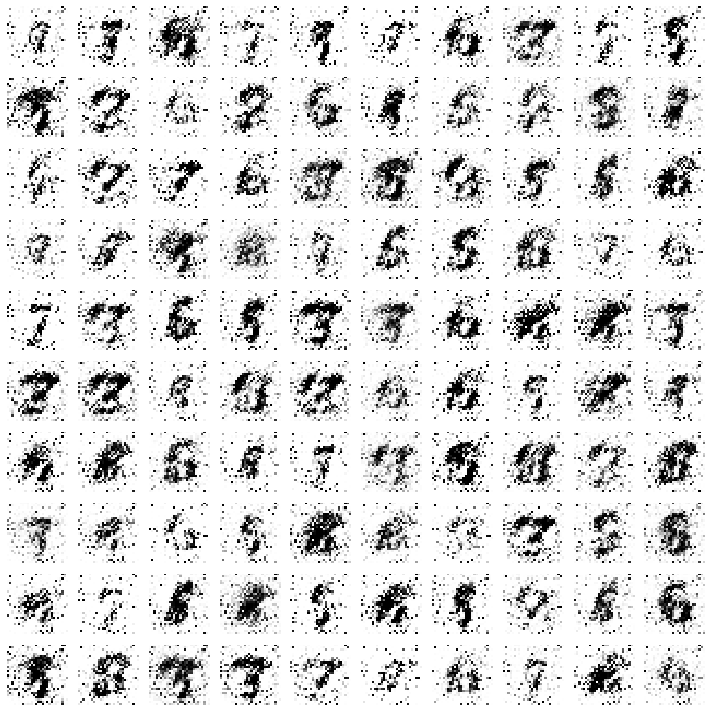

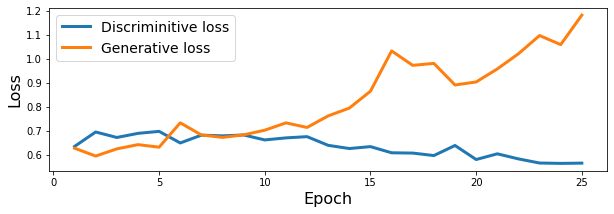

--------------- Epoch 26 ---------------


100%|██████████| 229/229 [00:02<00:00, 92.34it/s]


--------------- Epoch 27 ---------------


100%|██████████| 229/229 [00:02<00:00, 91.99it/s]


--------------- Epoch 28 ---------------


100%|██████████| 229/229 [00:02<00:00, 92.79it/s]


--------------- Epoch 29 ---------------


100%|██████████| 229/229 [00:02<00:00, 90.62it/s]


--------------- Epoch 30 ---------------


100%|██████████| 229/229 [00:02<00:00, 92.99it/s]


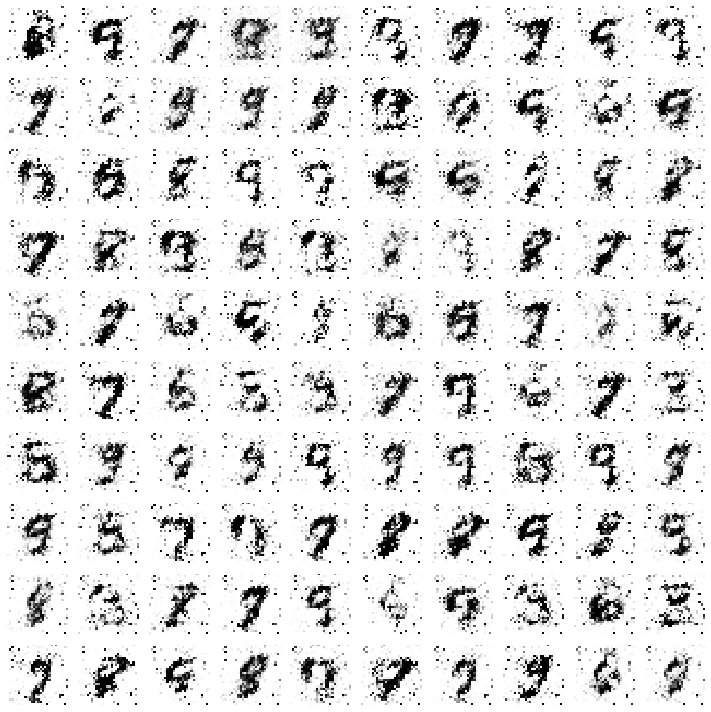

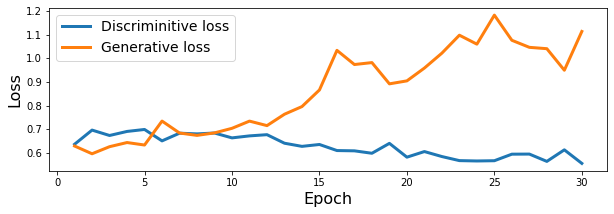

--------------- Epoch 31 ---------------


100%|██████████| 229/229 [00:02<00:00, 90.57it/s]


--------------- Epoch 32 ---------------


100%|██████████| 229/229 [00:02<00:00, 90.99it/s]


--------------- Epoch 33 ---------------


100%|██████████| 229/229 [00:02<00:00, 92.99it/s]


--------------- Epoch 34 ---------------


100%|██████████| 229/229 [00:02<00:00, 90.89it/s]


--------------- Epoch 35 ---------------


100%|██████████| 229/229 [00:02<00:00, 92.29it/s]


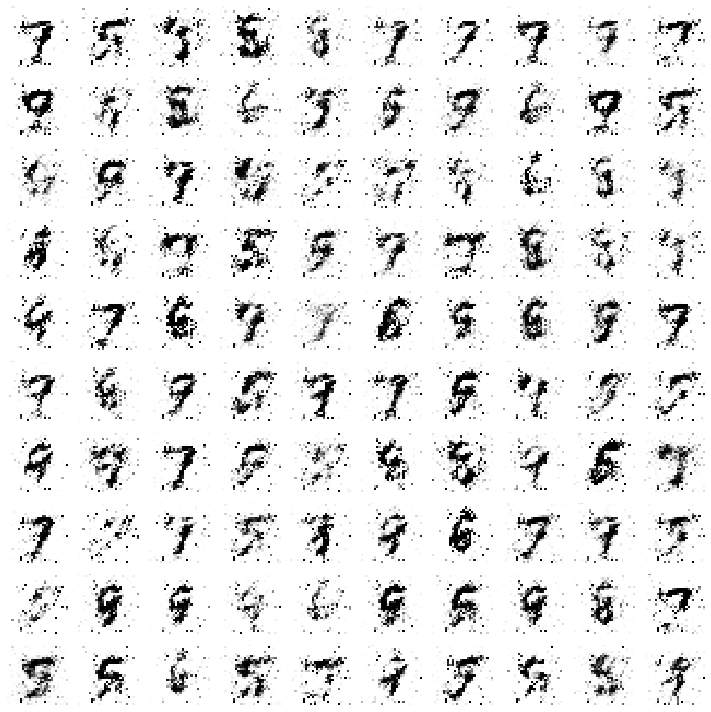

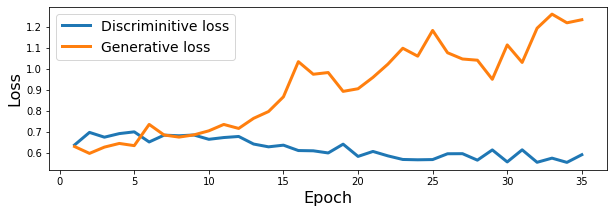

--------------- Epoch 36 ---------------


100%|██████████| 229/229 [00:02<00:00, 90.33it/s]


--------------- Epoch 37 ---------------


100%|██████████| 229/229 [00:02<00:00, 90.79it/s]


--------------- Epoch 38 ---------------


100%|██████████| 229/229 [00:02<00:00, 89.90it/s]


--------------- Epoch 39 ---------------


100%|██████████| 229/229 [00:02<00:00, 91.84it/s]


--------------- Epoch 40 ---------------


100%|██████████| 229/229 [00:02<00:00, 89.53it/s]


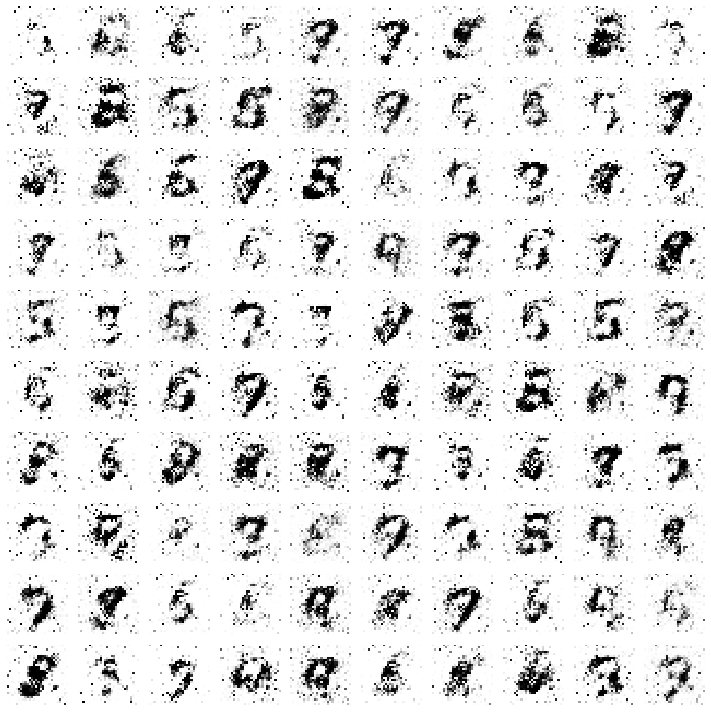

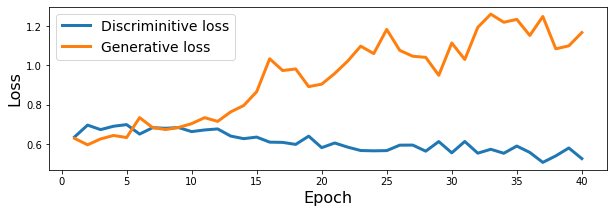

--------------- Epoch 41 ---------------


100%|██████████| 229/229 [00:02<00:00, 89.23it/s]


--------------- Epoch 42 ---------------


100%|██████████| 229/229 [00:02<00:00, 88.87it/s]


--------------- Epoch 43 ---------------


100%|██████████| 229/229 [00:02<00:00, 88.75it/s]


--------------- Epoch 44 ---------------


100%|██████████| 229/229 [00:02<00:00, 87.09it/s]


--------------- Epoch 45 ---------------


100%|██████████| 229/229 [00:02<00:00, 87.05it/s]


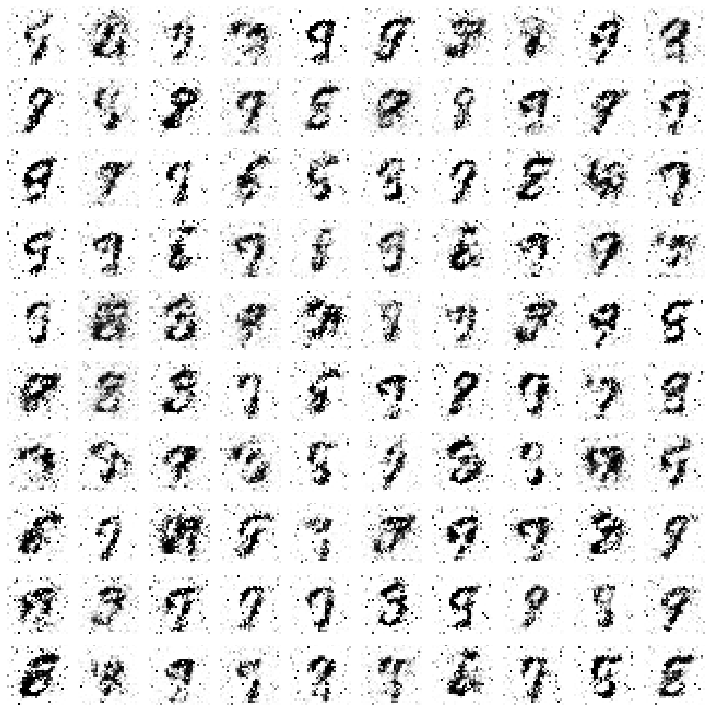

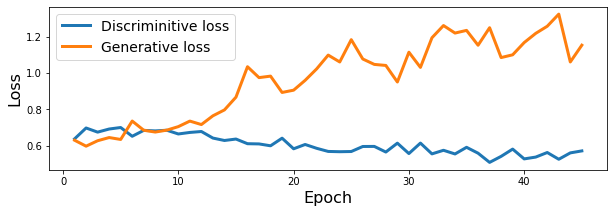

--------------- Epoch 46 ---------------


100%|██████████| 229/229 [00:02<00:00, 89.38it/s]


--------------- Epoch 47 ---------------


100%|██████████| 229/229 [00:02<00:00, 87.38it/s]


--------------- Epoch 48 ---------------


100%|██████████| 229/229 [00:02<00:00, 85.32it/s]


--------------- Epoch 49 ---------------


100%|██████████| 229/229 [00:02<00:00, 87.82it/s]


--------------- Epoch 50 ---------------


100%|██████████| 229/229 [00:02<00:00, 87.13it/s]


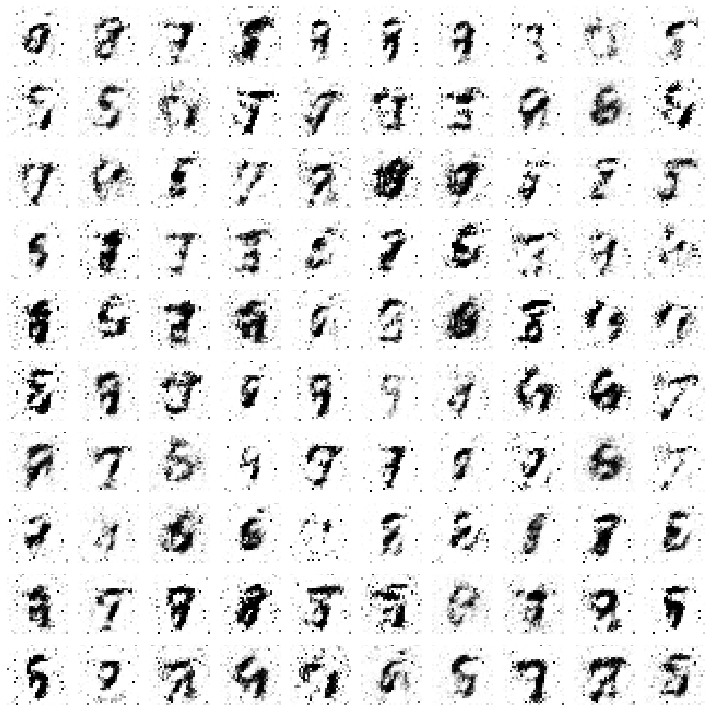

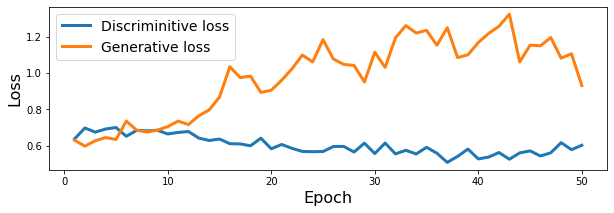

--------------- Epoch 51 ---------------


100%|██████████| 229/229 [00:02<00:00, 78.22it/s]


--------------- Epoch 52 ---------------


100%|██████████| 229/229 [00:02<00:00, 84.88it/s]


--------------- Epoch 53 ---------------


100%|██████████| 229/229 [00:02<00:00, 85.52it/s]


--------------- Epoch 54 ---------------


100%|██████████| 229/229 [00:02<00:00, 86.13it/s]


--------------- Epoch 55 ---------------


100%|██████████| 229/229 [00:02<00:00, 84.46it/s]


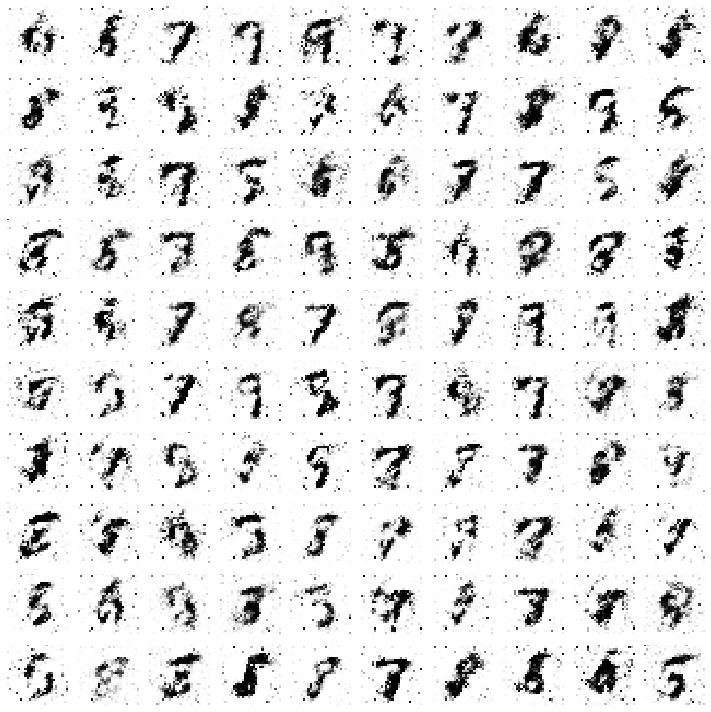

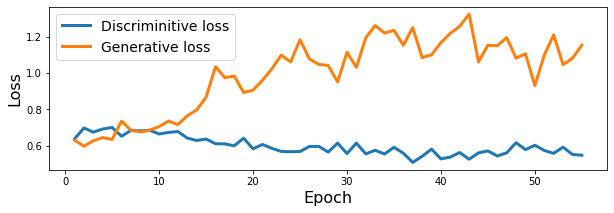

--------------- Epoch 56 ---------------


100%|██████████| 229/229 [00:02<00:00, 84.94it/s]


--------------- Epoch 57 ---------------


100%|██████████| 229/229 [00:02<00:00, 83.75it/s]


--------------- Epoch 58 ---------------


100%|██████████| 229/229 [00:02<00:00, 85.29it/s]


--------------- Epoch 59 ---------------


100%|██████████| 229/229 [00:02<00:00, 84.93it/s]


--------------- Epoch 60 ---------------


100%|██████████| 229/229 [00:02<00:00, 86.88it/s]


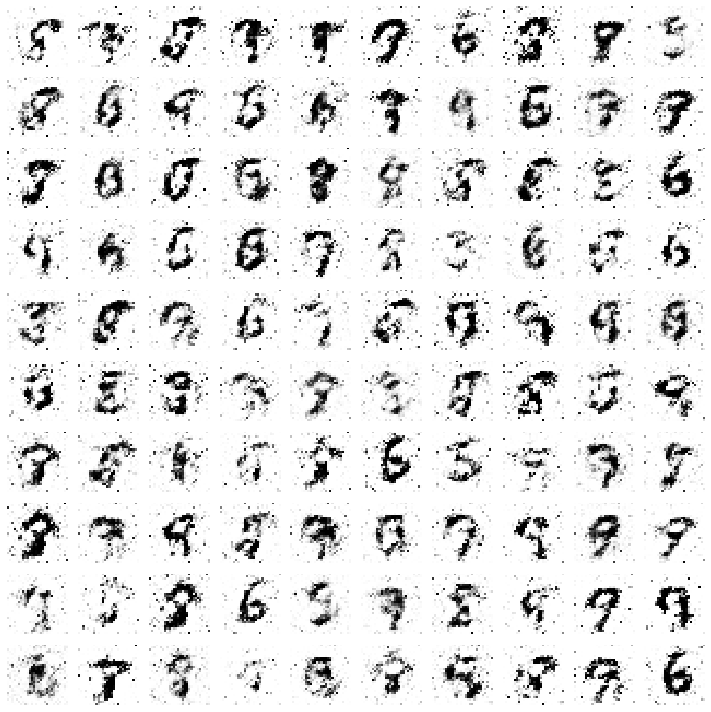

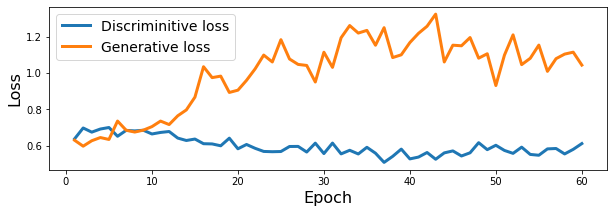

--------------- Epoch 61 ---------------


100%|██████████| 229/229 [00:02<00:00, 85.46it/s]


--------------- Epoch 62 ---------------


100%|██████████| 229/229 [00:02<00:00, 86.95it/s]


--------------- Epoch 63 ---------------


100%|██████████| 229/229 [00:02<00:00, 84.84it/s]


--------------- Epoch 64 ---------------


100%|██████████| 229/229 [00:02<00:00, 82.43it/s]


--------------- Epoch 65 ---------------


100%|██████████| 229/229 [00:02<00:00, 87.06it/s]


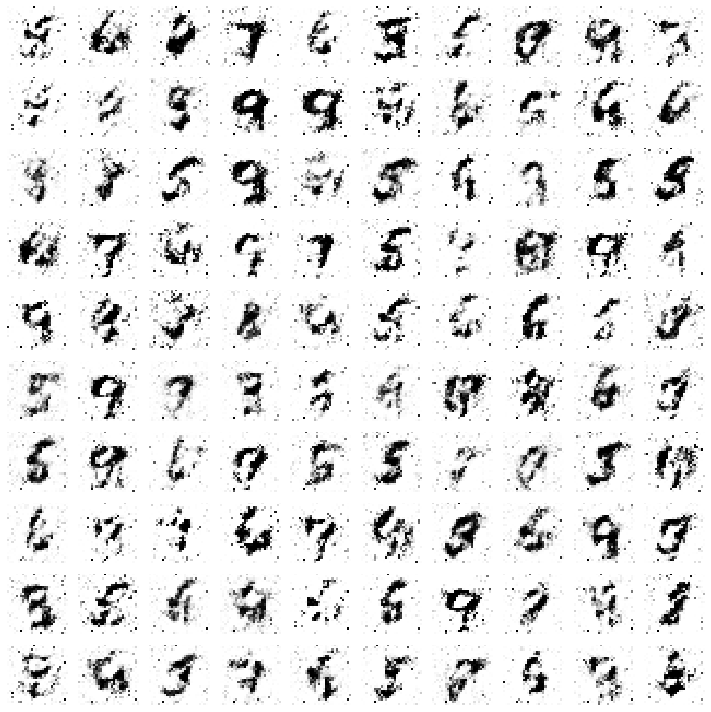

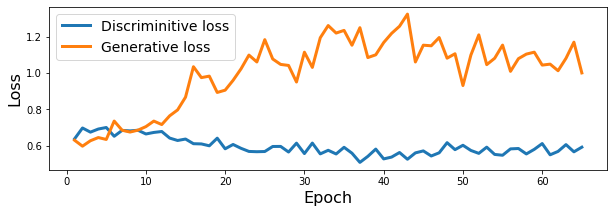

--------------- Epoch 66 ---------------


100%|██████████| 229/229 [00:02<00:00, 83.07it/s]


--------------- Epoch 67 ---------------


100%|██████████| 229/229 [00:02<00:00, 83.85it/s]


--------------- Epoch 68 ---------------


100%|██████████| 229/229 [00:02<00:00, 83.68it/s]


--------------- Epoch 69 ---------------


100%|██████████| 229/229 [00:02<00:00, 83.84it/s]


--------------- Epoch 70 ---------------


100%|██████████| 229/229 [00:02<00:00, 84.07it/s]


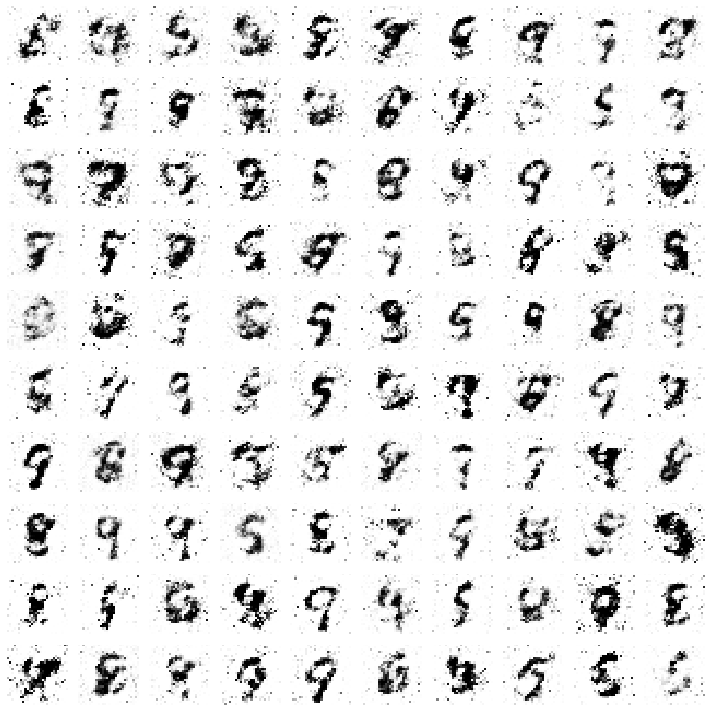

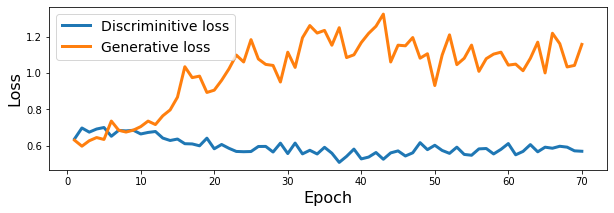

--------------- Epoch 71 ---------------


100%|██████████| 229/229 [00:02<00:00, 84.40it/s]


--------------- Epoch 72 ---------------


100%|██████████| 229/229 [00:02<00:00, 83.71it/s]


--------------- Epoch 73 ---------------


100%|██████████| 229/229 [00:02<00:00, 82.49it/s]


--------------- Epoch 74 ---------------


100%|██████████| 229/229 [00:02<00:00, 82.72it/s]


--------------- Epoch 75 ---------------


100%|██████████| 229/229 [00:02<00:00, 82.80it/s]


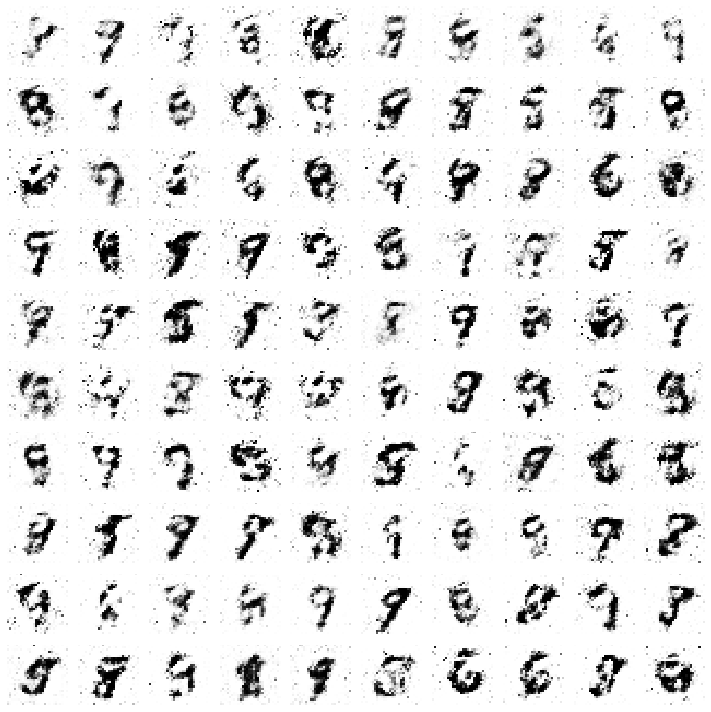

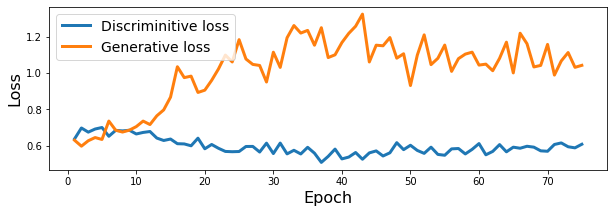

--------------- Epoch 76 ---------------


100%|██████████| 229/229 [00:02<00:00, 82.76it/s]


--------------- Epoch 77 ---------------


100%|██████████| 229/229 [00:02<00:00, 81.67it/s]


--------------- Epoch 78 ---------------


100%|██████████| 229/229 [00:02<00:00, 82.07it/s]


--------------- Epoch 79 ---------------


100%|██████████| 229/229 [00:02<00:00, 80.17it/s]


--------------- Epoch 80 ---------------


100%|██████████| 229/229 [00:02<00:00, 82.23it/s]


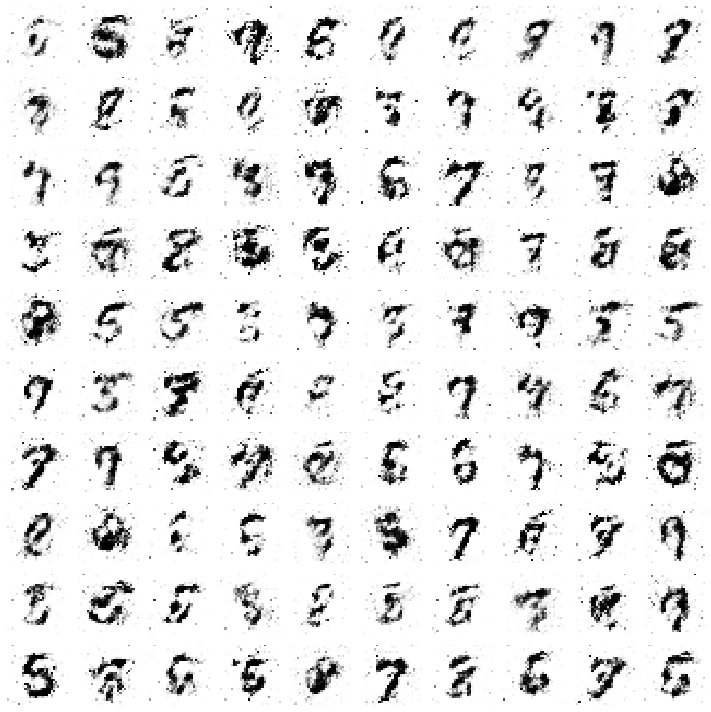

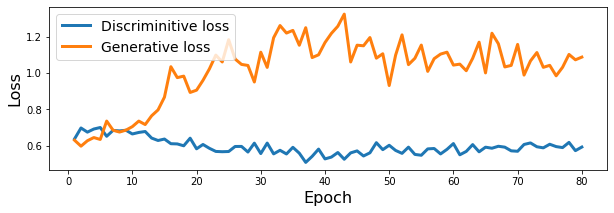

--------------- Epoch 81 ---------------


100%|██████████| 229/229 [00:02<00:00, 81.33it/s]


--------------- Epoch 82 ---------------


100%|██████████| 229/229 [00:02<00:00, 80.17it/s]


--------------- Epoch 83 ---------------


100%|██████████| 229/229 [00:02<00:00, 80.45it/s]


--------------- Epoch 84 ---------------


100%|██████████| 229/229 [00:02<00:00, 80.15it/s]


--------------- Epoch 85 ---------------


100%|██████████| 229/229 [00:02<00:00, 81.63it/s]


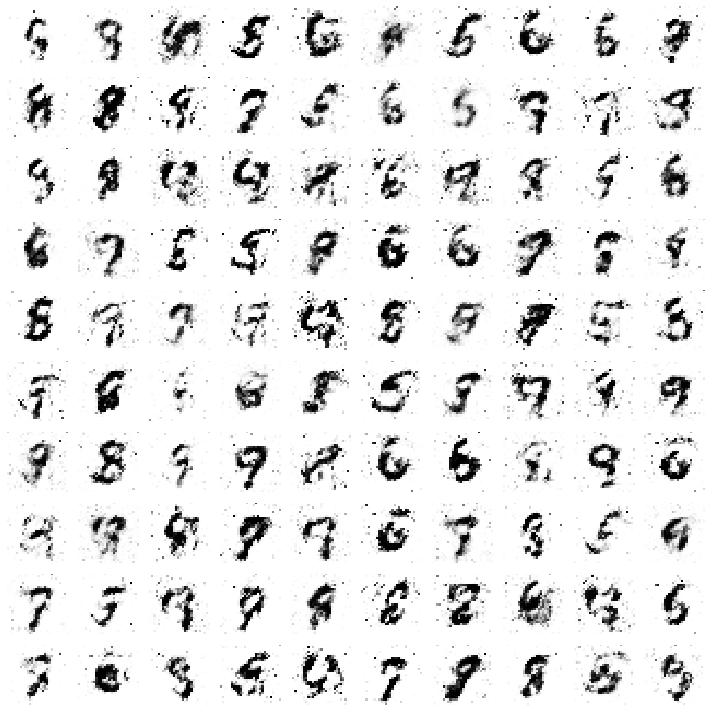

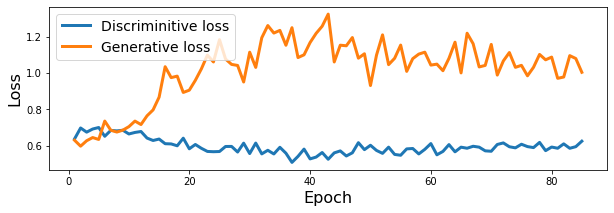

--------------- Epoch 86 ---------------


100%|██████████| 229/229 [00:02<00:00, 82.03it/s]


--------------- Epoch 87 ---------------


100%|██████████| 229/229 [00:02<00:00, 79.29it/s]


--------------- Epoch 88 ---------------


100%|██████████| 229/229 [00:02<00:00, 80.07it/s]


--------------- Epoch 89 ---------------


100%|██████████| 229/229 [00:02<00:00, 79.81it/s]


--------------- Epoch 90 ---------------


100%|██████████| 229/229 [00:02<00:00, 80.89it/s]


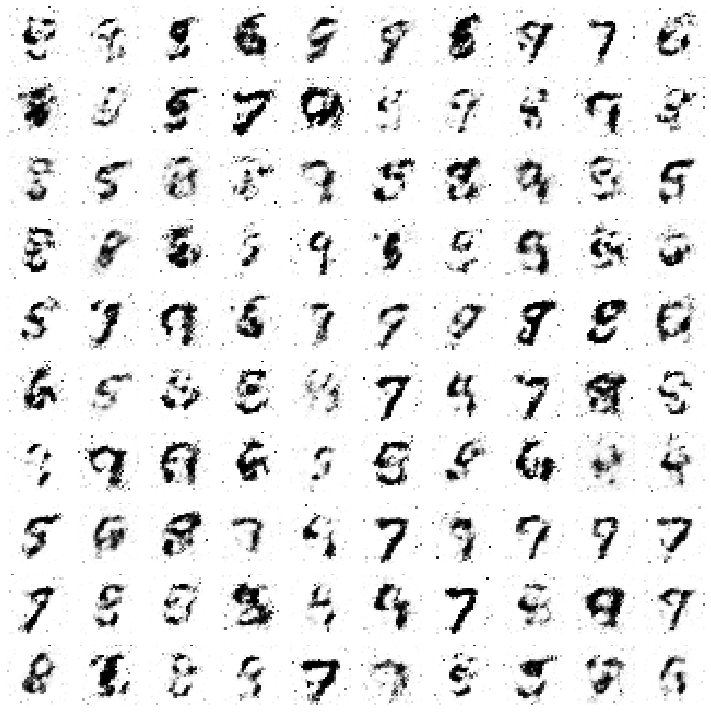

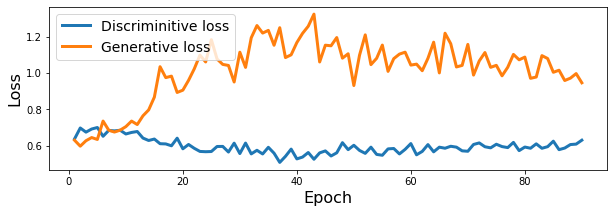

--------------- Epoch 91 ---------------


100%|██████████| 229/229 [00:02<00:00, 81.07it/s]


--------------- Epoch 92 ---------------


100%|██████████| 229/229 [00:02<00:00, 79.21it/s]


--------------- Epoch 93 ---------------


100%|██████████| 229/229 [00:02<00:00, 79.03it/s]


--------------- Epoch 94 ---------------


100%|██████████| 229/229 [00:02<00:00, 79.94it/s]


--------------- Epoch 95 ---------------


100%|██████████| 229/229 [00:02<00:00, 79.77it/s]


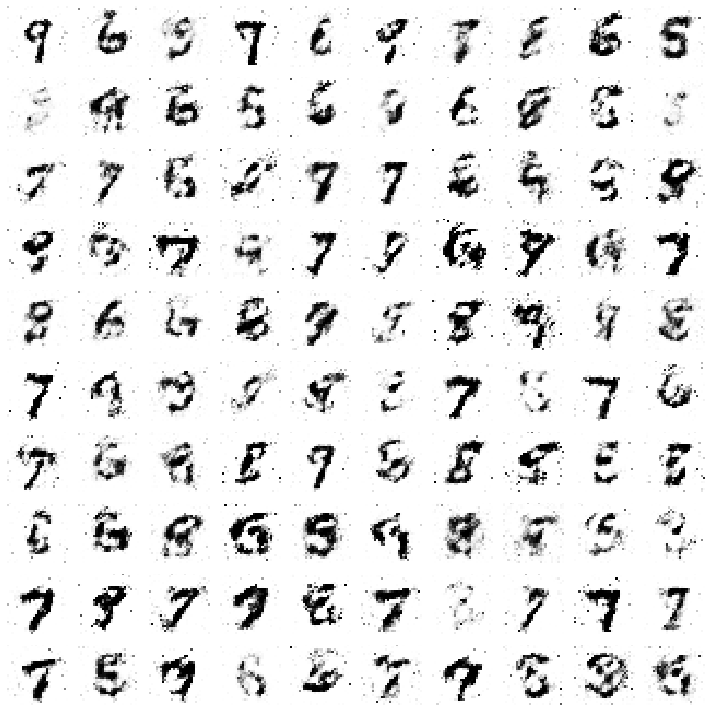

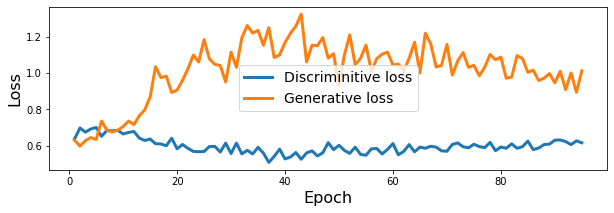

--------------- Epoch 96 ---------------


100%|██████████| 229/229 [00:02<00:00, 79.31it/s]


--------------- Epoch 97 ---------------


100%|██████████| 229/229 [00:02<00:00, 77.12it/s]


--------------- Epoch 98 ---------------


100%|██████████| 229/229 [00:02<00:00, 79.44it/s]


--------------- Epoch 99 ---------------


100%|██████████| 229/229 [00:02<00:00, 78.99it/s]


--------------- Epoch 100 ---------------


100%|██████████| 229/229 [00:02<00:00, 79.63it/s]


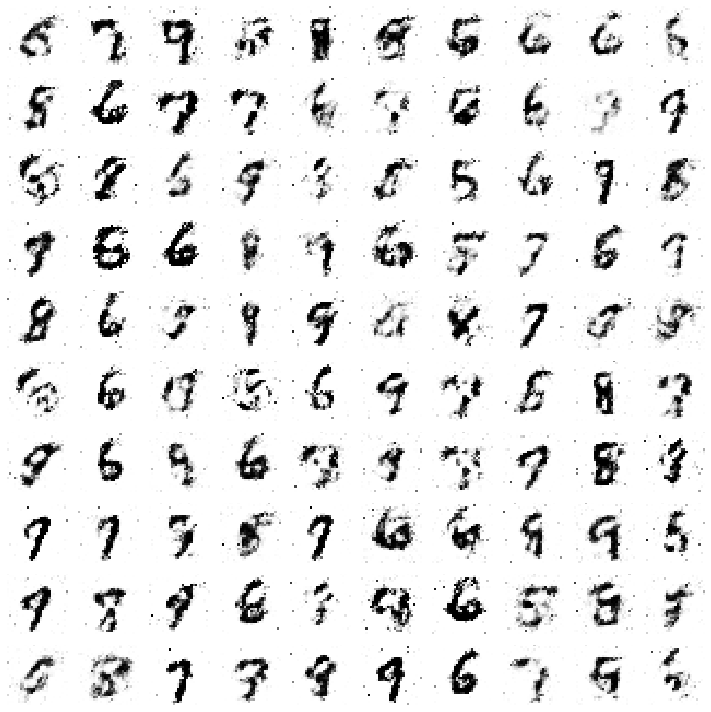

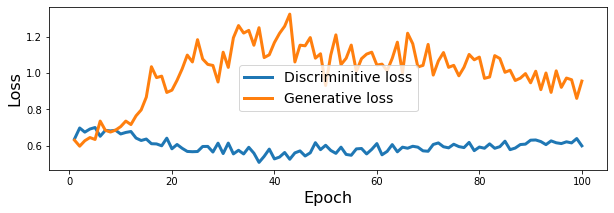

--------------- Epoch 101 ---------------


100%|██████████| 229/229 [00:02<00:00, 77.32it/s]


--------------- Epoch 102 ---------------


100%|██████████| 229/229 [00:02<00:00, 77.83it/s]


--------------- Epoch 103 ---------------


100%|██████████| 229/229 [00:02<00:00, 78.00it/s]


--------------- Epoch 104 ---------------


100%|██████████| 229/229 [00:02<00:00, 78.32it/s]


--------------- Epoch 105 ---------------


100%|██████████| 229/229 [00:02<00:00, 76.67it/s]


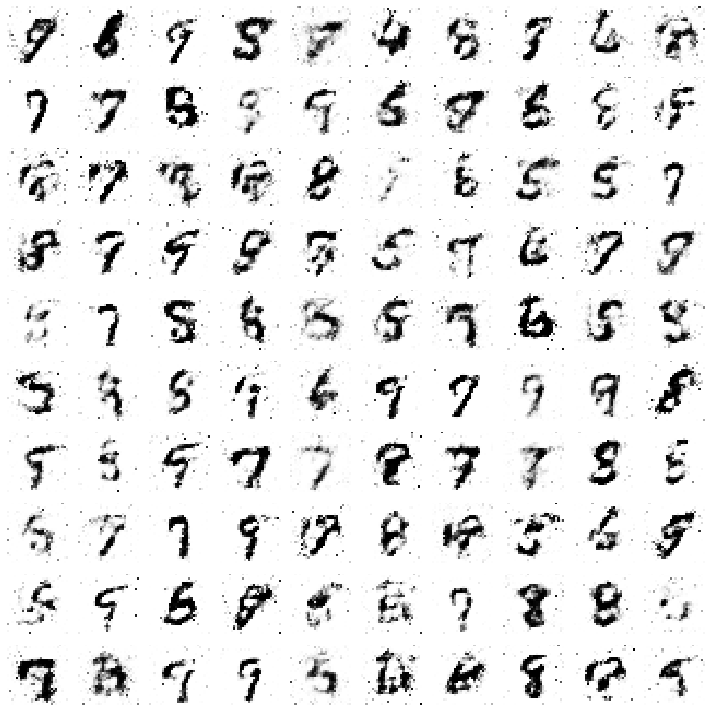

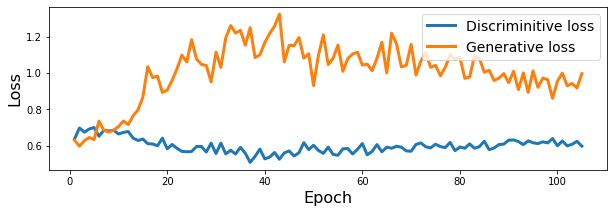

--------------- Epoch 106 ---------------


100%|██████████| 229/229 [00:02<00:00, 77.50it/s]


--------------- Epoch 107 ---------------


100%|██████████| 229/229 [00:02<00:00, 78.88it/s]


--------------- Epoch 108 ---------------


100%|██████████| 229/229 [00:03<00:00, 74.23it/s]


--------------- Epoch 109 ---------------


100%|██████████| 229/229 [00:02<00:00, 77.66it/s]


--------------- Epoch 110 ---------------


100%|██████████| 229/229 [00:03<00:00, 75.68it/s]


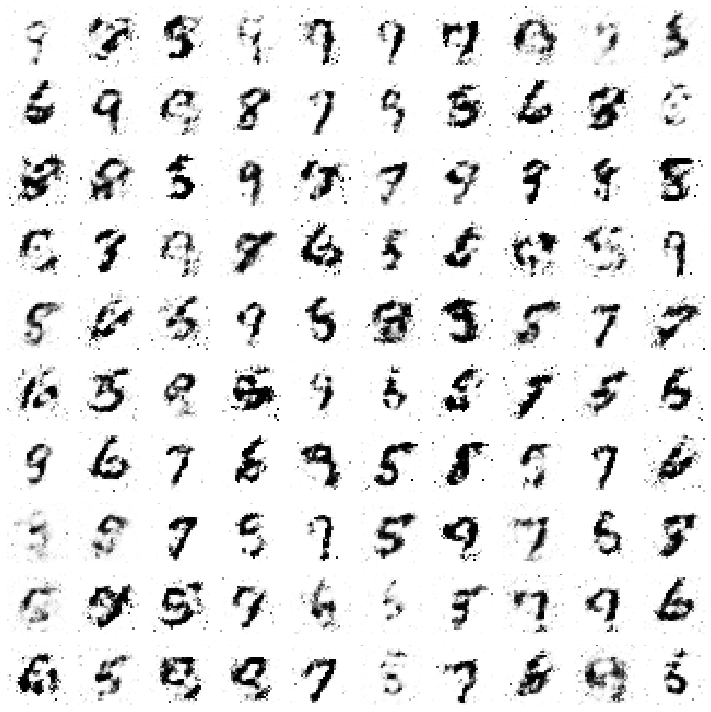

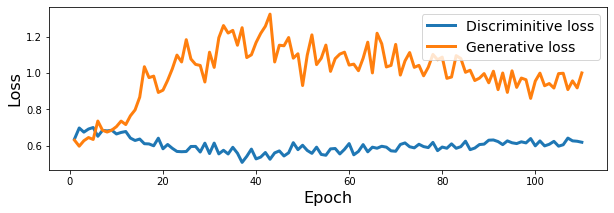

--------------- Epoch 111 ---------------


100%|██████████| 229/229 [00:02<00:00, 76.53it/s]


--------------- Epoch 112 ---------------


100%|██████████| 229/229 [00:03<00:00, 74.68it/s]


--------------- Epoch 113 ---------------


100%|██████████| 229/229 [00:02<00:00, 78.34it/s]


--------------- Epoch 114 ---------------


100%|██████████| 229/229 [00:03<00:00, 74.09it/s]


--------------- Epoch 115 ---------------


100%|██████████| 229/229 [00:03<00:00, 75.35it/s]


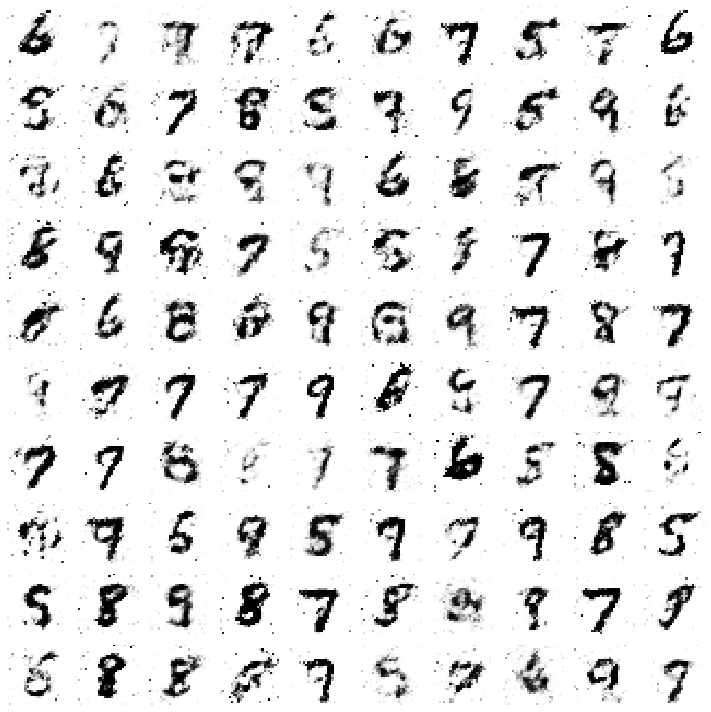

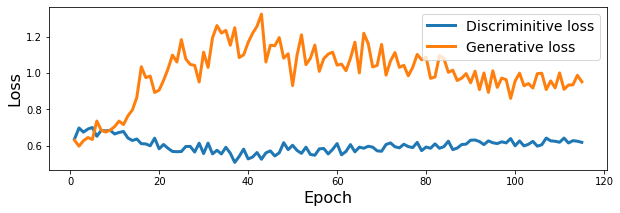

--------------- Epoch 116 ---------------


100%|██████████| 229/229 [00:03<00:00, 75.10it/s]


--------------- Epoch 117 ---------------


100%|██████████| 229/229 [00:03<00:00, 74.70it/s]


--------------- Epoch 118 ---------------


100%|██████████| 229/229 [00:02<00:00, 77.09it/s]


--------------- Epoch 119 ---------------


100%|██████████| 229/229 [00:03<00:00, 74.22it/s]


--------------- Epoch 120 ---------------


100%|██████████| 229/229 [00:03<00:00, 75.08it/s]


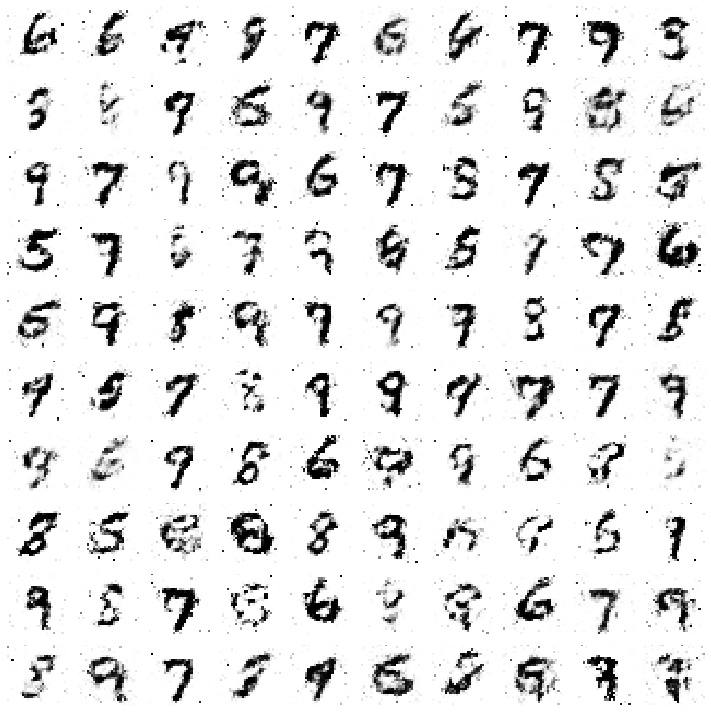

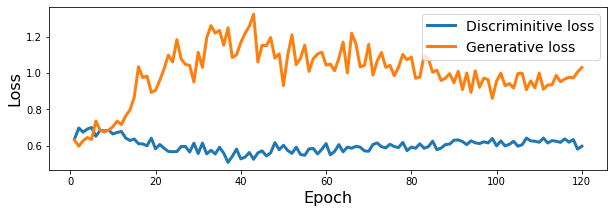

--------------- Epoch 121 ---------------


100%|██████████| 229/229 [00:03<00:00, 68.36it/s]


--------------- Epoch 122 ---------------


100%|██████████| 229/229 [00:03<00:00, 73.38it/s]


--------------- Epoch 123 ---------------


100%|██████████| 229/229 [00:03<00:00, 73.72it/s]


--------------- Epoch 124 ---------------


100%|██████████| 229/229 [00:03<00:00, 74.20it/s]


--------------- Epoch 125 ---------------


100%|██████████| 229/229 [00:03<00:00, 74.09it/s]


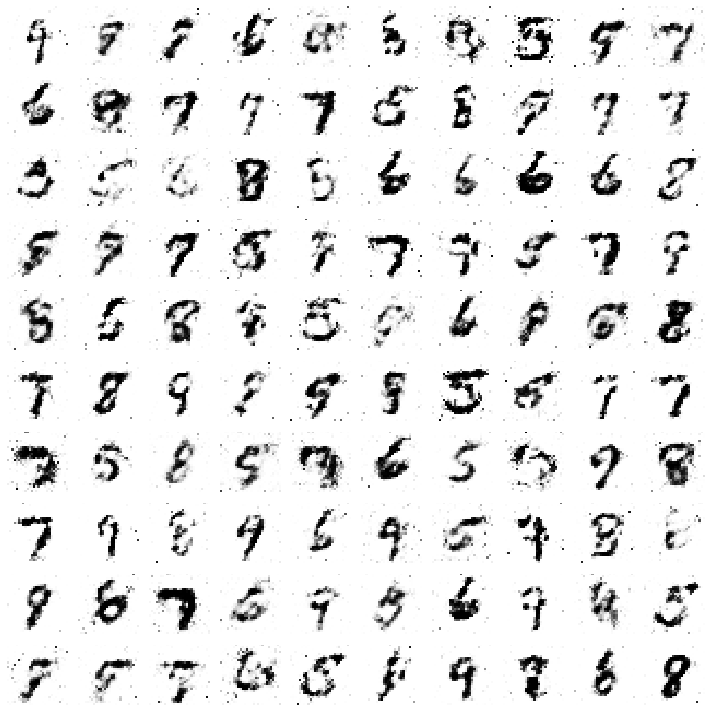

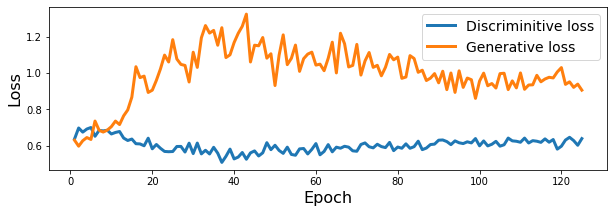

--------------- Epoch 126 ---------------


100%|██████████| 229/229 [00:03<00:00, 75.23it/s]


--------------- Epoch 127 ---------------


100%|██████████| 229/229 [00:03<00:00, 73.49it/s]


--------------- Epoch 128 ---------------


100%|██████████| 229/229 [00:03<00:00, 73.30it/s]


--------------- Epoch 129 ---------------


100%|██████████| 229/229 [00:03<00:00, 73.56it/s]


--------------- Epoch 130 ---------------


100%|██████████| 229/229 [00:03<00:00, 72.94it/s]


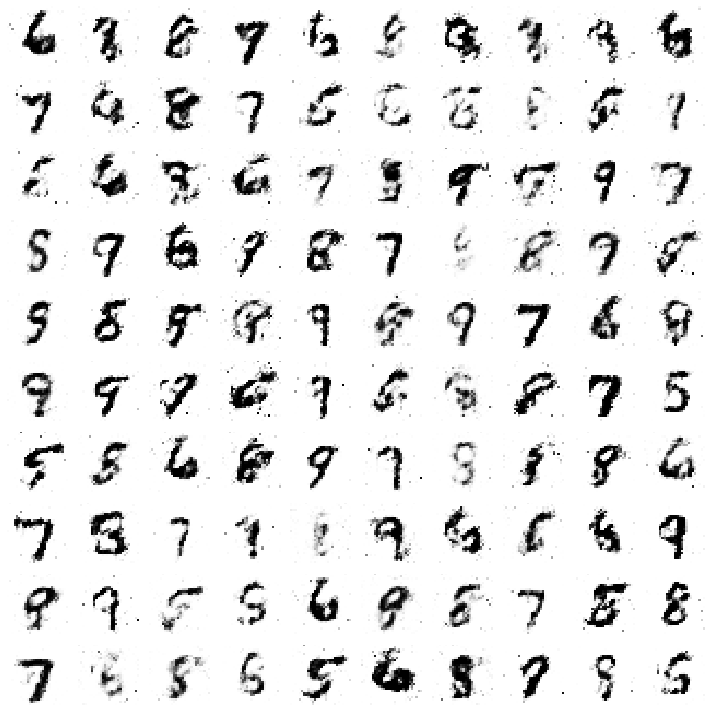

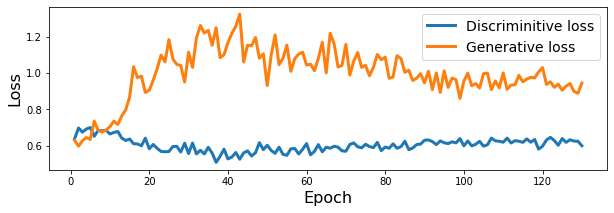

--------------- Epoch 131 ---------------


100%|██████████| 229/229 [00:03<00:00, 73.09it/s]


--------------- Epoch 132 ---------------


100%|██████████| 229/229 [00:03<00:00, 72.82it/s]


--------------- Epoch 133 ---------------


100%|██████████| 229/229 [00:03<00:00, 72.89it/s]


--------------- Epoch 134 ---------------


100%|██████████| 229/229 [00:03<00:00, 73.77it/s]


--------------- Epoch 135 ---------------


100%|██████████| 229/229 [00:03<00:00, 74.30it/s]


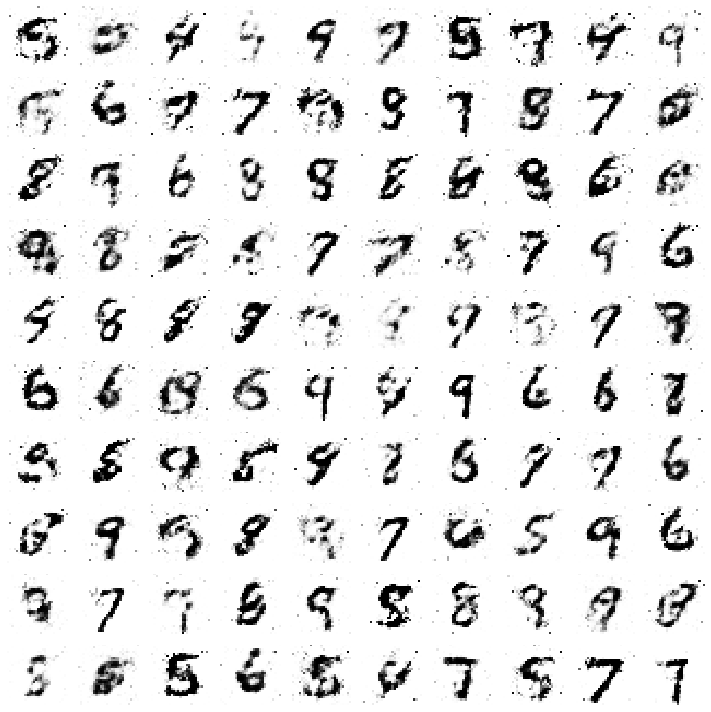

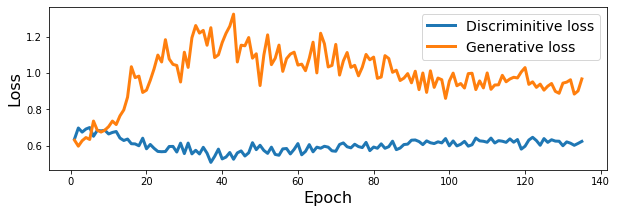

--------------- Epoch 136 ---------------


100%|██████████| 229/229 [00:03<00:00, 73.08it/s]


--------------- Epoch 137 ---------------


100%|██████████| 229/229 [00:03<00:00, 71.95it/s]


--------------- Epoch 138 ---------------


100%|██████████| 229/229 [00:03<00:00, 71.30it/s]


--------------- Epoch 139 ---------------


100%|██████████| 229/229 [00:03<00:00, 71.95it/s]


--------------- Epoch 140 ---------------


100%|██████████| 229/229 [00:03<00:00, 72.23it/s]


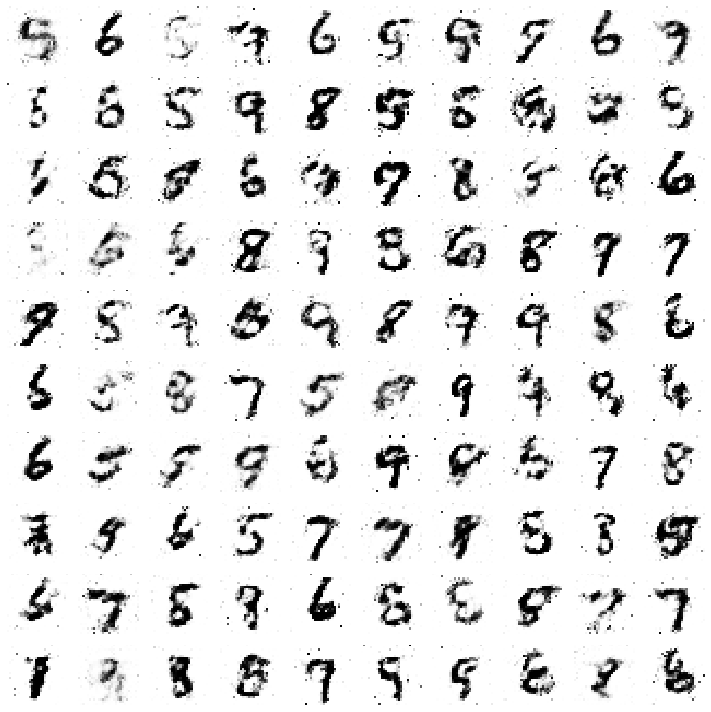

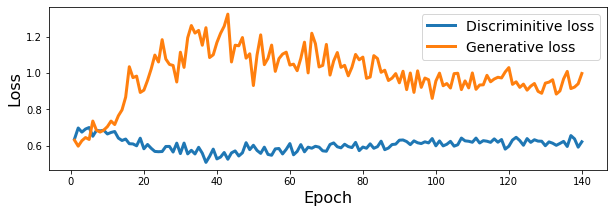

--------------- Epoch 141 ---------------


100%|██████████| 229/229 [00:03<00:00, 72.20it/s]


--------------- Epoch 142 ---------------


100%|██████████| 229/229 [00:03<00:00, 72.25it/s]


--------------- Epoch 143 ---------------


100%|██████████| 229/229 [00:03<00:00, 70.59it/s]


--------------- Epoch 144 ---------------


100%|██████████| 229/229 [00:03<00:00, 72.61it/s]


--------------- Epoch 145 ---------------


100%|██████████| 229/229 [00:03<00:00, 71.22it/s]


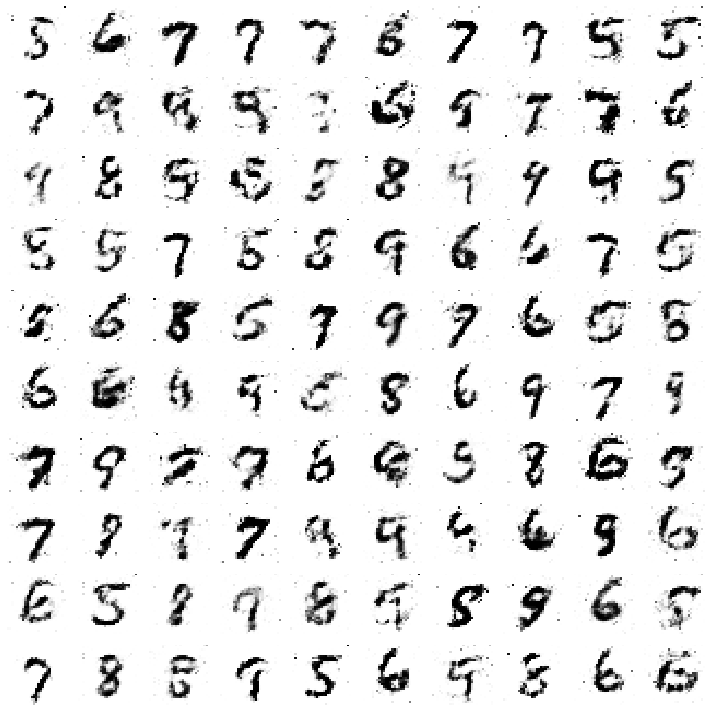

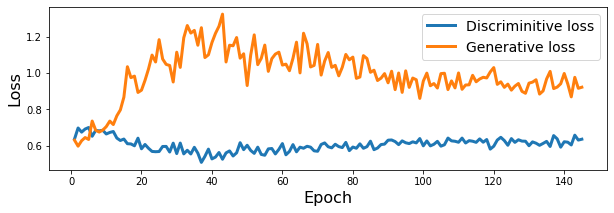

--------------- Epoch 146 ---------------


100%|██████████| 229/229 [00:03<00:00, 72.04it/s]


--------------- Epoch 147 ---------------


100%|██████████| 229/229 [00:03<00:00, 71.47it/s]


--------------- Epoch 148 ---------------


100%|██████████| 229/229 [00:03<00:00, 70.74it/s]


--------------- Epoch 149 ---------------


100%|██████████| 229/229 [00:03<00:00, 71.43it/s]


--------------- Epoch 150 ---------------


100%|██████████| 229/229 [00:03<00:00, 70.48it/s]


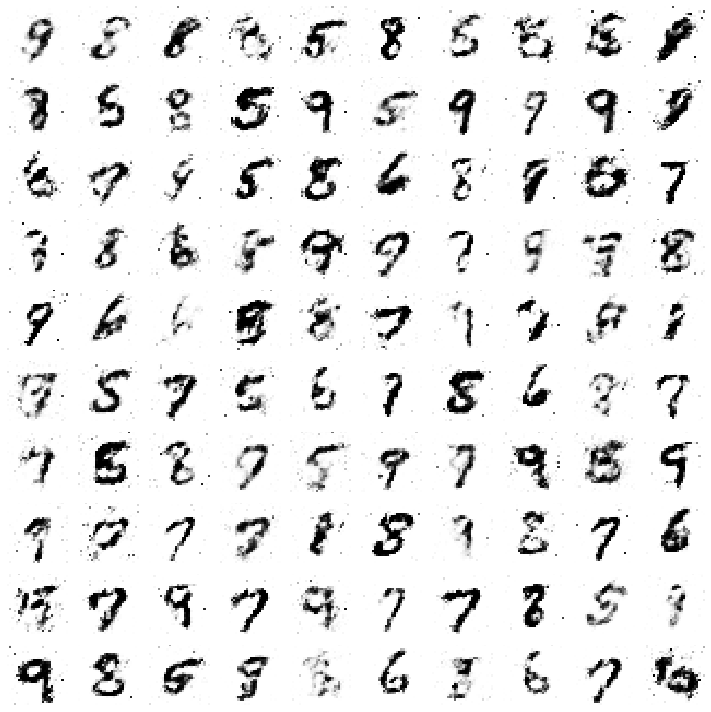

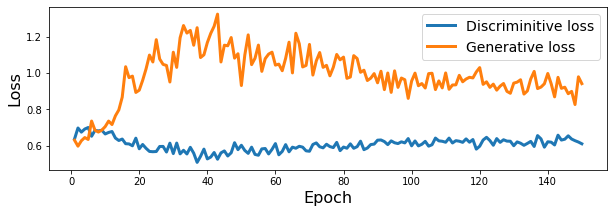

--------------- Epoch 151 ---------------


100%|██████████| 229/229 [00:03<00:00, 71.92it/s]


--------------- Epoch 152 ---------------


100%|██████████| 229/229 [00:03<00:00, 67.45it/s]


--------------- Epoch 153 ---------------


100%|██████████| 229/229 [00:03<00:00, 71.48it/s]


--------------- Epoch 154 ---------------


100%|██████████| 229/229 [00:03<00:00, 70.85it/s]


--------------- Epoch 155 ---------------


100%|██████████| 229/229 [00:03<00:00, 69.11it/s]


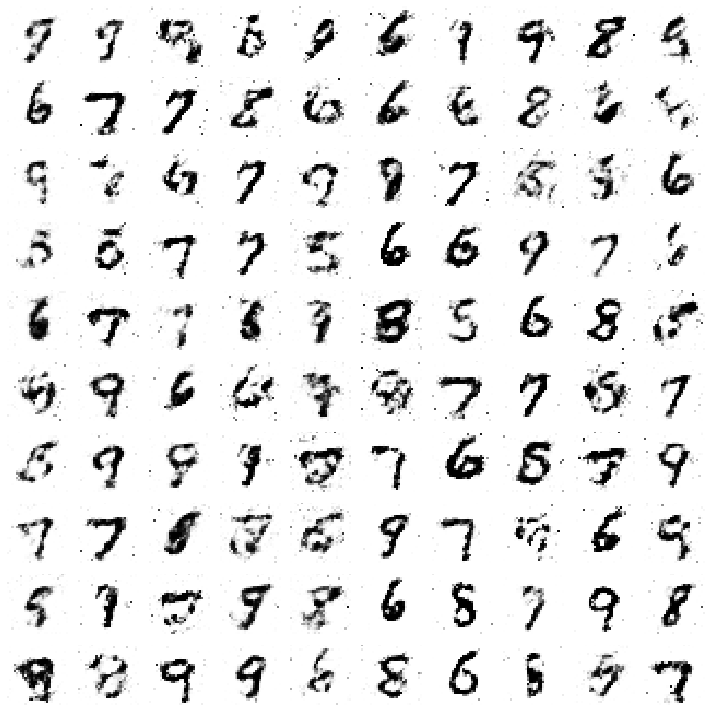

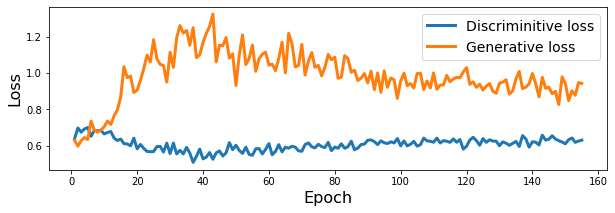

--------------- Epoch 156 ---------------


 45%|████▌     | 104/229 [00:01<00:01, 67.04it/s]


KeyboardInterrupt: ignored

In [ ]:
print('Epochs:', epochs)
print('Batch size:', batchSize)
print('Batches per epoch:', batchCount)

for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in tqdm(range(batchCount)):
        # Get a random set of input noise and images
        # Genero entrada aleatoria al generador para 128 imágenes:
        noise = np.random.normal(0, 1, size=[batchSize, randomDim])

        # Generate fake MNIST images
        # genero 128 (batchSize) imágenes falsas
        generatedImages = generator.predict(noise)

        # cojo al azar 128 (batchSize) imágenes reales
        imageBatch = X_train[np.random.randint(0, len(X_train), size=batchSize)]

        # las 128 primeras imágenes son reales
        # y las 128 siguientes fake
        X = np.concatenate([imageBatch, generatedImages])
        
        # Labels for generated and real data --> 0.1: fake / 0.9 (1): real --> No se usa 1 porque la sigmoide nunca llega a 1 --> se usa 0.9 generalmente y 0.1 por abajo
        yDis = batchSize*[0.9] + batchSize*[0.1]
        
        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)
        

        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize, randomDim])
        yGen = batchSize*[1] # El 1 es la etiqueta deseada. Yo quiero que mi generador genere imágenes que logren que el discriminador de un valor real (1)
        discriminator.trainable = False # Congelo el discriminador (no entreno los dos a la vez)
        gloss = gan.train_on_batch(noise, yGen)

    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)
    
    if (e==1) or ((e%5)==0):
        plotGeneratedImages(e)
        if SAVE_INTERMEDIATE_DATA:
            saveModels(e)
    if (e%5)==0:
        plotLoss(e)

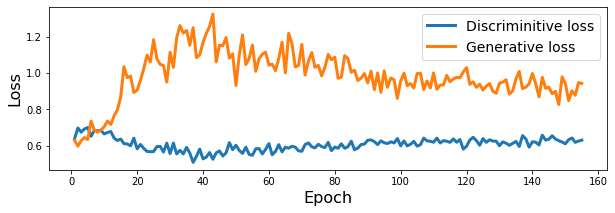

In [ ]:
# Plot losses from every epoch
plotLoss(e)

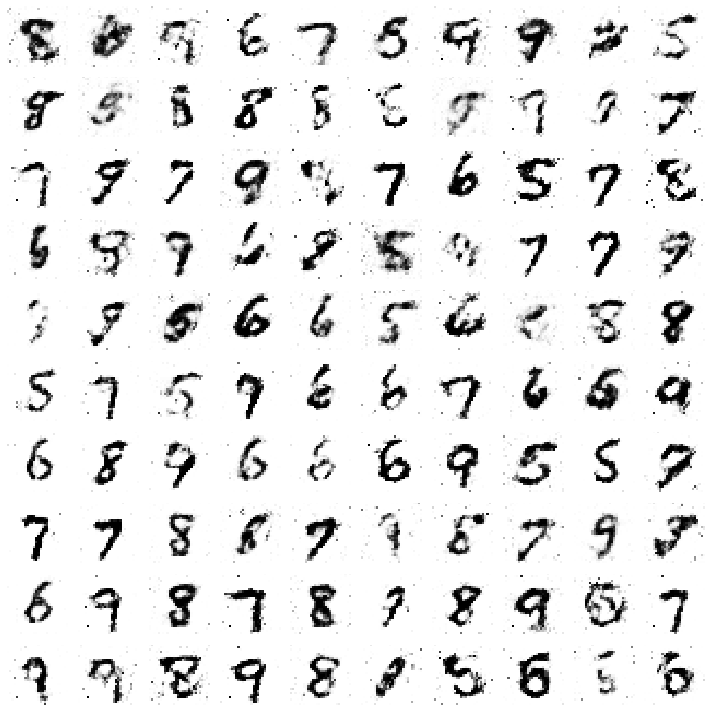

In [ ]:
plotGeneratedImages(e+1)

Ahora generamos un conjunto de vectores de entrada a la GAN. Cada vector de entrada tiene **randomDim** componentes:

In [ ]:
randomDim

50

In [ ]:
# Vamos a mostrar los resultados obtenidos para el conjunto de vectores
# de entrada en una matriz de nfilas * ncols:
nfilas = 20
ncols  = 20

# Inicializo a 0 el conjunto de vectores de entrada a la GAN:
input0 = np.zeros((nfilas*ncols, randomDim))

# Termino de calcular el conjunto de vectores de entrada.
# La idea es que en cada fila las componentes diferentes de cero
# son las mismas, y sus valores cambian de columna a columna:

nvector = 0
for i in range(nfilas):
    # Qué componentes de las randomDim se van a perturbar:
    componentes_pert = range(i,i+1)
    for j,x in enumerate(np.linspace(-4, 4, ncols)):
        input_id = i+0
        input0[nvector][componentes_pert] = x
        nvector = nvector + 1

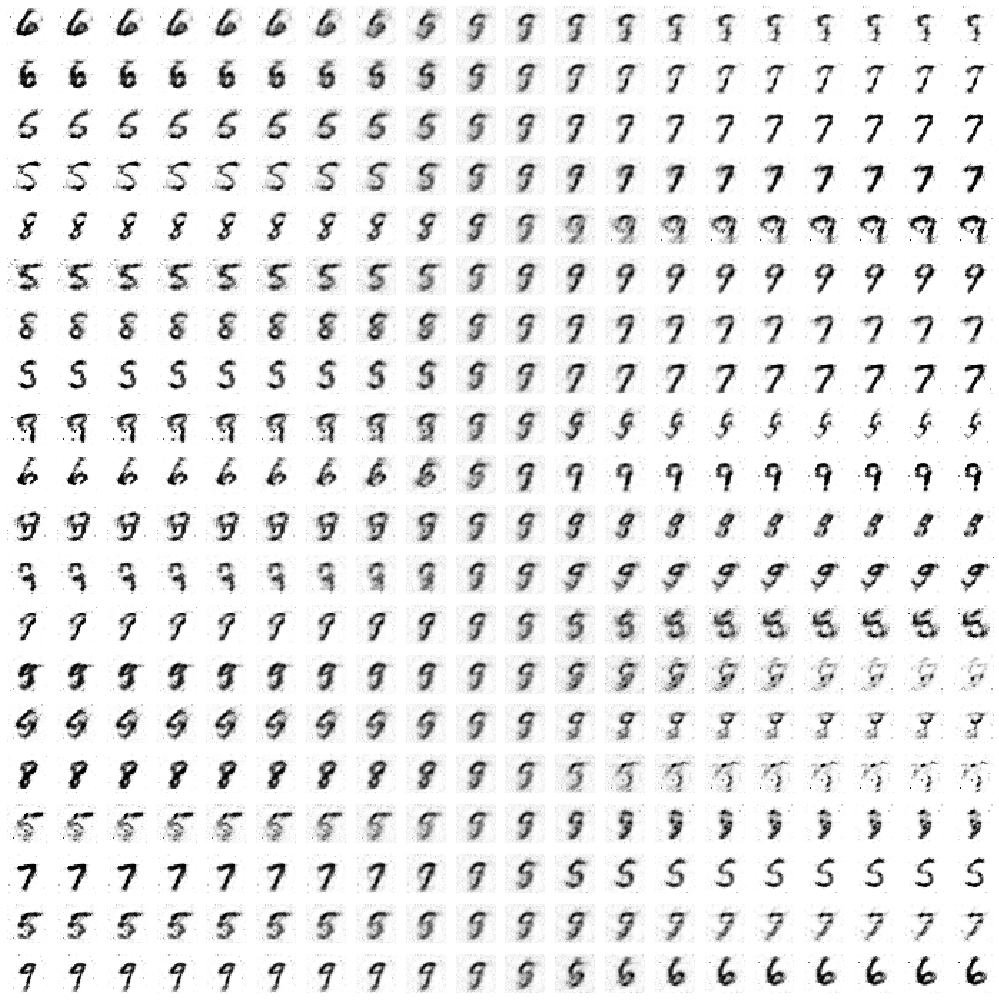

In [ ]:
generatedImages = generator.predict(input0)
plotImages(generatedImages, nfilas, ncols, figsize=(14,14))

In [ ]:
generatedImages.shape

In [ ]:
# Para grabar las redes a fichero:

generator.save("./generator.h5")
generator.save_weights("./generator_weights.h5")
discriminator.save("./discriminator.h5")
discriminator.save_weights("./discriminator_weights.h5")
gan.save("./gan.h5")
gan.save_weights("./gan_weights.h5")

Para descargar el modelo a local si estamos en Colab:

In [ ]:
if COLAB:
    from google.colab import files
    files.download('./generator.h5')
    files.download('./generator_weights.h5')
    files.download('./discriminator.h5')
    files.download('./discriminator_weights.h5')
    files.download('./gan.h5')
    files.download('./gan_weights.h5')

Si quisiésemos realizar **data augmentation** desde otro script, haríamos lo siguiente:

In [ ]:
from keras.models import load_model

model_data_augmentation = load_model("./generator.h5")

In [ ]:
model_data_augmentation.summary()

In [ ]:
model_data_augmentation.input_shape

In [ ]:
numero_patrones_sinteticos = 1000
tam_entrada_generador = model_data_augmentation.input_shape[-1]
input_gen = np.random.randn(numero_patrones_sinteticos, tam_entrada_generador)

patrones_nuevos = model_data_augmentation.predict(input_gen)

In [ ]:
patrones_nuevos.shape

In [ ]:
plotImages(patrones_nuevos[:20], nfilas, ncols, figsize=(14,7))